## Text Data from Amazon's Annual Reports

This is a TidyTuesday (and also a PydyTuesday) project! Check out the data source info here at the Tidy Tuesday GitHub repo: https://github.com/rfordatascience/tidytuesday/tree/main



In [6]:
import pandas as pd
import requests
import PyDyTuesday as pdt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
import datetime


In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-03-25/report_words_clean.csv')

In [9]:
#pdt.get_date('2025-03-25')
df.head()

,year,word
0,2005,shareholders
1,2005,decisions
2,2005,amazon.com
3,2005,data
4,2005,answer


In [14]:
df.groupby('year', as_index=False).agg(
   word_count=pd.NamedAgg(column='word', aggfunc='count')
)

,year,word_count
0,2005,22977
1,2006,20560
2,2007,20554
3,2008,20338
4,2009,18454
5,2010,18205
6,2011,19839
7,2012,20394
8,2013,21975
9,2014,22919


In [18]:
df.groupby(
   ['year','word'], as_index=False
).agg(
   word_count=pd.NamedAgg(column='word', aggfunc='count')
)

,year,word,word_count
0,2005,aaa,3
1,2005,ability,23
2,2005,abroad,1
3,2005,absolute,9
4,2005,accelerate,1
...,...,...,...
58245,2023,yoy,9
58246,2023,zapolsky,4
58247,2023,zealand,1
58248,2023,zone,1


In [83]:
# Most Popular Words per Year
grouped_counts = (df.groupby('year')['word'].value_counts()
.rename('counts').reset_index()
.drop_duplicates('year'))

grouped_counts = grouped_counts.reset_index()
grouped_counts

,index,year,word,counts
0,0,2005,million,397
1,2779,2006,million,339
2,5534,2007,million,318
3,8337,2008,million,281
4,11026,2009,million,212
5,13662,2010,net,191
6,16451,2011,net,202
7,19433,2012,net,191
8,22376,2013,million,202
9,25846,2014,cash,236


In [33]:
# gather all words per year
corpus = df.pivot_table(index="year", values=["word"], aggfunc=lambda x: ", ".join(x))
#corpus = corpus.reset_index()


In [34]:
# using Vader for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score

corpus['sentiment_score'] = corpus.apply(get_sentiment, axis=1)

In [35]:
#Splitting score up 
corpus['negative'] = corpus['sentiment_score'].apply(lambda x: x.get('neg', 0))
corpus['neutral'] = corpus['sentiment_score'].apply(lambda x: x.get('neu', 0))
corpus['positive'] = corpus['sentiment_score'].apply(lambda x: x.get('pos', 0))
corpus['compound'] = corpus['sentiment_score'].apply(lambda x: x.get('compound', 0))
corpus=corpus.reset_index()


In [68]:
#exporting corpus to csv
corpus.to_csv('corpus.csv',index=True)

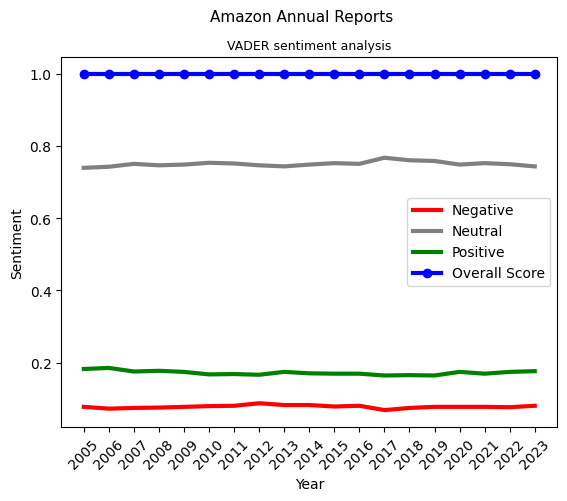

In [67]:
fig, ax = plt.subplots()

ax.plot(
    'year', 'negative', data=corpus,
    marker='', # marker type
    markerfacecolor='red', # color of marker
    markersize=12, # size of marker
    color='red', # color of line
    linewidth=3, # change width of line
    label="Negative" # label for legend
)

ax.plot(
    'year', 'neutral', data=corpus,
    marker='', # no marker
    color='gray', # color of line
    #linestyle='dashed', # change type of line
    linewidth=3, # change width of line
    label="Neutral" # label for legend
)

ax.plot(
    'year', 'positive', data=corpus,
    marker='', # no marker
    color='green', # color of line
    linewidth=3, # change width of line
    label="Positive" # label for legend
)

ax.plot(
    'year', 'compound', data=corpus,
    marker='o', # no marker
    color='blue', # color of line
    linewidth=3, # change width of line
    label="Overall Score" # label for legend
)

# Format the x-axis as full years
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) # Ticks at every 1 year
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}')) # No decimal places

plt.xticks(rotation=45)

plt.xlabel("Year")
plt.ylabel("Sentiment")
plt.suptitle("Amazon Annual Reports", fontsize=11)
plt.title("VADER sentiment analysis", fontsize=9)

# show legend
plt.legend()

# show graph
plt.show()


In [77]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv('keys.env')

openai_api_key = os.getenv("OPENAI_API_KEY")

# Check if key loaded correctly
if openai_api_key is None:
    raise Exception("API Key not found. Make sure your .env file contains OPENAI_API_KEY value.")



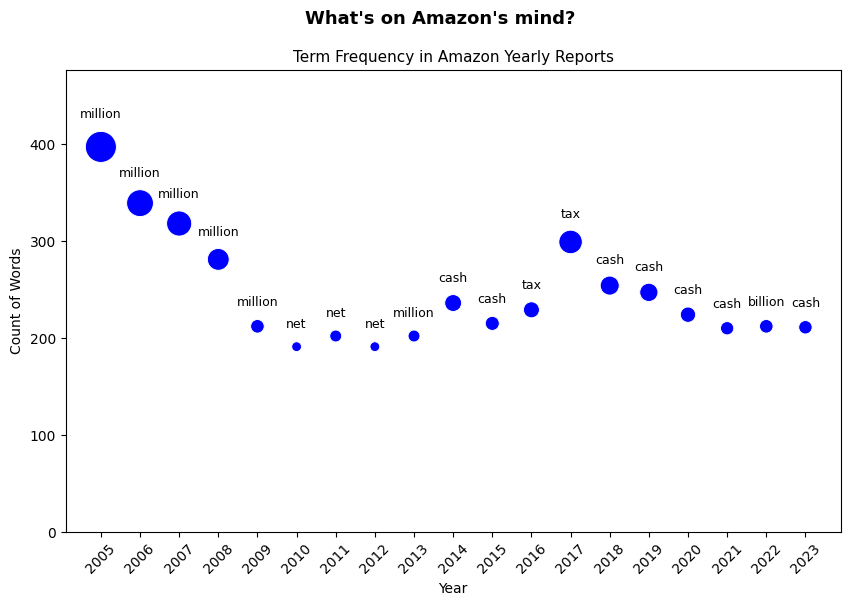

In [96]:


# Set up the figure
plt.figure(figsize=(10, 6))

# Create scatter plot with dot size proportional to counts
sns.scatterplot(x="year", y="counts", data=grouped_counts, size="counts", sizes=(50, 500), color="blue", legend=False)

# Add word annotations above each dot (x axis position, y axis position + offset, label to print, horizontal alignment)
for i, row in grouped_counts.iterrows():
    plt.text(row["year"], row["counts"] + row["counts"] * 0.05 + 10, row["word"], ha='center', fontsize=9)

# Adjust y-axis limits to prevent words from being cut off
plt.ylim(0, max(grouped_counts["counts"]) * 1.2)  # Increase upper limit by 20%

# Formatting
plt.xticks(range(min(grouped_counts["year"]), max(grouped_counts["year"]) + 1), rotation=45)
plt.xlabel("Year")
plt.ylabel("Count of Words")
plt.suptitle("What's on Amazon's mind?", fontsize=13, fontweight='bold')
plt.title("Term Frequency in Amazon Yearly Reports", fontsize=11)

plt.show()
